# Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

# General Function

## Read

In [2]:
def preprocess_name(imgpath, label):
    imgname = imgpath.split(".")[0]
    if label == "1":
        return imgname+"_p"
    else:
        return imgname+"_n"

def read_images(csvdir):
    with open(csvdir, newline="") as csvfile:
        imgs = dict()
        reader = csv.DictReader(csvfile)
        pcount = 0
        ncount = 0
        for row in reader:
            img_name = preprocess_name(row["ImagePath"].split("/")[-1], row["Labels"])
            bgr_img = cv2.imread(row["ImagePath"], cv2.IMREAD_UNCHANGED)
            imgs[img_name] = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
        
        return imgs

## Display

In [3]:
def display_all(imgs, subs=(84,4), fgsz=(5,170), use_gray=False):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=fgsz)
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            axs[i, j].imshow(list(imgs.values())[k], 'gray' if use_gray else None)
            axs[i, j].set_title(list(imgs.keys())[k])
            axs[i, j].axis('off')
            k+=1
            
def display_all_with(imgs, cc, subs=(84,4), fgsz=(5,170), use_gray=True):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=fgsz)
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            axs[i, j].imshow(list(imgs.values())[k][:,:,cc], cmap='gray' if use_gray else None)
            axs[i, j].set_title(list(imgs.keys())[k])
            axs[i, j].axis('off')
            k+=1
            
def save_plots(imgs, suptitle, savedir, subs=(84,4), fgsz=(5,170), use_gray=False):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=fgsz)
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            axs[i, j].imshow(list(imgs.values())[k], 'gray' if use_gray else None)
            axs[i, j].set_title(list(imgs.keys())[k])
            axs[i, j].axis('off')
            k+=1
    fig.suptitle(suptitle)
    fig.savefig(savedir)
    print(f'Figure is successfully saved at {savedir}')
    
def display_all_histo(imgs, subs=(84,4), fgsz=(5,170)):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=fgsz)
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            # print(list(imgs.values())[k])
            sample_histo = cv2.calcHist([list(imgs.values())[k]],[0],None,[256],[0,256]) 
            axs[i, j].plot(sample_histo)
            axs[i, j].set_title(list(imgs.keys())[k])
            axs[i, j].axis('off')
            k+=1

## Preprocess

### Gamma Correction

In [25]:
def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0,256)]).astype("uint8")
    return cv2.LUT(image, table)

### Remove Blood Vessel

In [4]:
def segment_vessel(imgs):
    vessel_segment = {} # for development purposes
    clahe_kernel = cv2.createCLAHE(2, (8,8))
    circular_SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (45,45))
    
    for img in imgs:
        # use grayscale image
        grayscale = cv2.cvtColor(imgs[img], cv2.COLOR_RGB2GRAY)
        # img negative
        img_negative = cv2.bitwise_not(grayscale)
        tophat = cv2.morphologyEx(img_negative, cv2.MORPH_TOPHAT, kernel=circular_SE)
        ret, th1 = cv2.threshold(tophat, 3, 255, cv2.THRESH_BINARY)
        vessel_segment[img] = th1
    return vessel_segment

In [5]:
def remove_bvessel(imgs):
    segmented_vessel = segment_vessel(imgs)
    without_vessel = {}
    for (k1, v1), (k2, v2) in zip(imgs.items(), segmented_vessel.items()):
        print(f'Processing {k1}...')
        without_vessel[k1] = cv2.inpaint(imgs[k1], segmented_vessel[k2], 25, cv2.INPAINT_TELEA)
    return without_vessel

## Segmentation

### Segmentasi OC

In [74]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import flood, flood_fill
from skimage.filters import sobel
from skimage.segmentation import clear_border

In [86]:
def set_bleeds(img):
    '''
    A bleed is a small area around the edge of 
    your artwork that extends beyond the “finished” 
    cut edge of your document.
    '''
    img[:, :100] = 0
    img[:100, :] = 0
    img[-100:, :] = 0
    img[:, -100:] = 0
    
    return img

In [96]:
def get_circle(contours):
    conts = np.array([contour.shape[0] for contour in contours])
    cont_idx = np.argmax(conts)
    (x,y), radius = cv2.minEnclosingCircle(contours[cont_idx])
    return (x,y), radius

def select_boundaries(bnrs):
    cont, hcy = cv2.findContours(bnrs, 
                                     cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    (x,y),radius = get_circle(cont)
    center = (int(x),int(y))
    radius = int(radius)
    return (center, radius)

In [97]:
def get_oc(images):
    screen = {}
    
    for image in images:
        h, w = images[image].shape[:2]
        green = images[image][:,:,1]
        rescaled = rescale_intensity(green)
        corrected = adjust_gamma(rescaled, 0.2)
        ret, th1 = cv2.threshold(corrected, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        eroded = cv2.erode(th1, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15)))
        bleeds = set_bleeds(eroded)
        closed = cv2.morphologyEx(bleeds, cv2.MORPH_CLOSE, \
                                  kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (55,55)))
        center_rad = select_boundaries(closed)
        paint_canvas = images[image].copy()
        screen[image] = cv2.circle(paint_canvas, center_rad[0], center_rad[1] ,(0,0,255),2)
        
    display_all(screen, use_gray=True)
    return None, None

# Main

## Read

In [8]:
IMAGES_CSV = r"../selected_dataset.csv"

In [9]:
images = read_images(IMAGES_CSV)

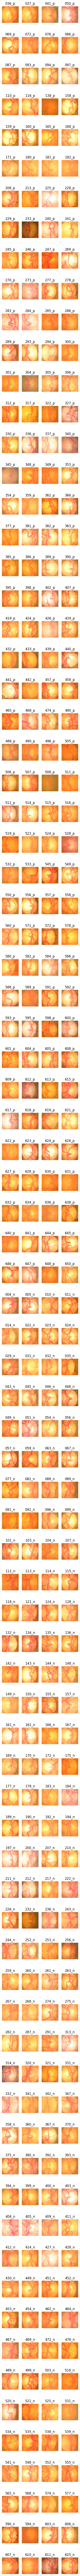

In [10]:
display_all(images)

## Blood Vessel Removal

In [11]:
no_vessel = remove_bvessel(images)

Processing 036_p...
Processing 037_p...
Processing 041_p...
Processing 050_p...
Processing 069_p...
Processing 072_p...
Processing 076_p...
Processing 086_p...
Processing 087_p...
Processing 093_p...
Processing 094_p...
Processing 097_p...
Processing 110_p...
Processing 116_p...
Processing 138_p...
Processing 158_p...
Processing 159_p...
Processing 160_p...
Processing 165_p...
Processing 168_p...
Processing 171_p...
Processing 180_p...
Processing 181_p...
Processing 182_p...
Processing 208_p...
Processing 213_p...
Processing 225_p...
Processing 228_p...
Processing 229_p...
Processing 233_p...
Processing 240_p...
Processing 241_p...
Processing 245_p...
Processing 246_p...
Processing 247_p...
Processing 269_p...
Processing 270_p...
Processing 273_p...
Processing 277_p...
Processing 278_p...
Processing 283_p...
Processing 284_p...
Processing 285_p...
Processing 286_p...
Processing 289_p...
Processing 293_p...
Processing 294_p...
Processing 300_p...
Processing 301_p...
Processing 304_p...


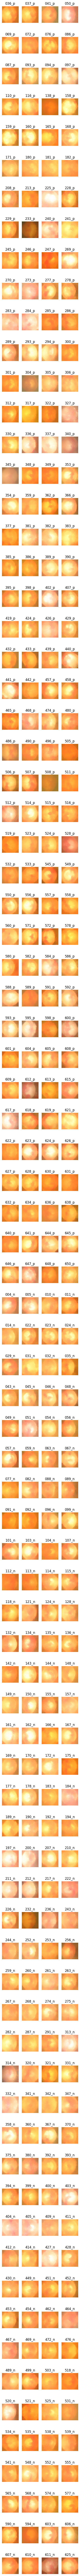

In [12]:
display_all(no_vessel)

## Segmentasi

In [ ]:
oc_boundaries, oc_binaries = get_oc(no_vessel)